In [20]:
%matplotlib inline

from __future__ import print_function

import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
# from keras.optimizers import *
from keras.utils import np_utils
import keras
import keras.backend as K
import glob
import json
from sklearn.model_selection import train_test_split

import math
import random
from IPython import display

import numpy as np
import matplotlib.pyplot as plt

import cv2

In [2]:
batch_size = 32
nb_classes = 10
nb_epoch = 200
eps=1e-11

zed = 100

def cifar():
    # input image dimensions
    img_rows, img_cols = 32, 32
    # the CIFAR10 images are RGB
    img_channels = 3

    # the data, shuffled and split between train and test sets
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    X_train-=0.5
    X_test-=0.5

    return X_train,Y_train,X_test,Y_test

print('loading cifar...')
xt, yt, xv, yv = cifar()

xt.shape

loading cifar...
X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


(50000, 32, 32, 3)

In [25]:
def load_icons():
    labels = []
    label_to_idx = {}
    icon_index = json.load(open('icons32/icon_index.json'))
    res = []
    labelled = []
    img_rows, img_cols = 32, 32    
    for img_path in glob.glob('icons32/*.bmp'):
        img = load_img(img_path, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        res.append(img)
        icon_name = img_path.rsplit('/', 1)[-1].split('.')[0].lower()
        label = icon_index[icon_name]
        if not label in label_to_idx:
            label_to_idx[label] = len(labels)
            labels.append(label)
        labelled.append(label_to_idx[label])
    res = (np.asarray(res) / 255) - 0.5
    
    x_train, y_train, x_val, y_val = train_test_split(res, labelled, train_size=0.85)
    return x_train, y_train, x_val, y_val, labels, label_to_idx

xt, yt, xv, yv, labels, label_to_idx = load_icons()
xt.shape

(3728, 32, 32, 3)

In [26]:
def relu(i):
    return LeakyReLU(.2)(i)

def bn(i):
    return BatchNormalization()(i)

In [27]:
def autoscaler(img):
    limit = 400.
    # scales = [0.1,0.125,1./6.,0.2,0.25,1./3.,1./2.] + range(100)
    scales = np.hstack([1./np.linspace(10,2,num=9), np.linspace(1,100,num=100)])

    imgscale = limit/float(img.shape[0])
    for s in scales:
        if s>=imgscale:
            imgscale=s
            break

    img = cv2.resize(img,dsize=(int(img.shape[1]*imgscale),int(img.shape[0]*imgscale)),interpolation=cv2.INTER_NEAREST)

    return img,imgscale

def flatten_multiple_image_into_image(arr):
    import cv2
    num,uh,uw,depth = arr.shape

    patches = int(num+1)
    height = int(math.sqrt(patches)*0.9)
    width = int(patches/height+1)

    img = np.zeros((height*uh+height, width*uw+width, 3),dtype='float32')

    index = 0
    for row in range(height):
        for col in range(width):
            if index>=num-1:
                break
            channels = arr[index]
            img[row*uh+row:row*uh+uh+row,col*uw+col:col*uw+uw+col,:] = channels
            index+=1

    img,imgscale = autoscaler(img)

    return img,imgscale


def show(save=False):
    i = np.random.normal(loc=0.,scale=1.,size=(batch_size,zed))
    gened = gm.predict([i])

    gened *= 0.5
    gened +=0.5

    im,ims = flatten_multiple_image_into_image(gened)
    plt.imshow(im)

    if save!=False:
        cv2.imwrite(save,im*255)

In [28]:
def gen2(): # generative network, 2
    inp = Input(shape=(zed,))
    i = inp
    i = Reshape((1,1,zed))(i)

    ngf=24

    def deconv(i,nop,kw,oh,ow,std=1,tail=True,bm='same'):
        global batch_size
        i = Deconvolution2D(nop,kw,kw,subsample=(std,std),border_mode=bm,output_shape=(batch_size,oh,ow,nop))(i)
        if tail:
            i = bn(i)
            i = relu(i)
        return i

    i = deconv(i,nop=ngf*8,kw=4,oh=4,ow=4,std=1,bm='valid')
    i = deconv(i,nop=ngf*4,kw=4,oh=8,ow=8,std=2)
    i = deconv(i,nop=ngf*2,kw=4,oh=16,ow=16,std=2)
    i = deconv(i,nop=ngf*1,kw=4,oh=32,ow=32,std=2)

    i = deconv(i,nop=3,kw=4,oh=32,ow=32,std=1,tail=False) # out : 32x32
    i = Activation('tanh')(i)

    m = Model(input=inp,output=i)
    return m

print('generating G...')
gm = gen2()
gm.summary()

generating G...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 192)         307392    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 192)         768       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 192)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 96)          295008    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 96)          384  

/home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(192, (4, 4), padding="valid", strides=(1, 1))`
  # Remove the CWD from sys.path while we load stuff.
/home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(96, (4, 4), padding="same", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(48, (4, 4), padding="same", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(24, (4, 4), p

In [29]:
def concat_diff(i): # batch discrimination -  increase generation diversity.
    # return i
    bv = Lambda(lambda x:K.mean(K.abs(x[:] - K.mean(x,axis=0)),axis=-1,keepdims=True))(i)
    i = merge([i,bv],mode='concat')
    return i

def dis2(): # discriminative network, 2
    # inp = Input(shape=(None,None,3))
    inp = Input(shape=(32,32,3))
    i = inp

    ndf=24

    def conv(i,nop,kw,std=1,usebn=True,bm='same'):
        i = Convolution2D(nop,kw,kw,border_mode=bm,subsample=(std,std))(i)
        if usebn:
            i = bn(i)
        i = relu(i)
        return i

    i = conv(i,ndf*1,4,std=2,usebn=False)
    i = concat_diff(i)
    i = conv(i,ndf*2,4,std=2)
    i = concat_diff(i)
    i = conv(i,ndf*4,4,std=2)
    i = concat_diff(i)
    i = conv(i,ndf*8,4,std=2)
    i = concat_diff(i)

    # 1x1
    i = Convolution2D(1,2,2,border_mode='valid')(i)

    i = Activation('linear',name='conv_exit')(i)
    i = Activation('sigmoid')(i)

    i = Reshape((1,))(i)

    m = Model(input=inp,output=i)
    return m

In [30]:
print('generating D...')
dm = dis2()
dm.summary()

generating D...


/home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (4, 4), padding="same", strides=(2, 2))`
  from ipykernel import kernelapp as app
/home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  after removing the cwd from sys.path.
/home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (4, 4), padding="same", strides=(2, 2))`
  from ipykern

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 24)        1176      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 24)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 16, 16, 1)         0         
_________________________________________________________________
merge_1 (Merge)              (None, 16, 16, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 48)          19248     
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 48)          192       
__________

/home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (2, 2), padding="valid")`
/home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


In [31]:
def gan(g,d):
    # initialize a GAN trainer

    # this is the fastest way to train a GAN in Keras
    # two models are updated simutaneously in one pass

    noise = Input(shape=g.input_shape[1:])
    real_data = Input(shape=d.input_shape[1:])

    generated = g(noise)
    gscore = d(generated)
    rscore = d(real_data)

    def log_eps(i):
        return K.log(i+1e-11)

    # single side label smoothing: replace 1.0 with 0.9
    dloss = - K.mean(log_eps(1-gscore) + .1 * log_eps(1-rscore) + .9 * log_eps(rscore))
    gloss = - K.mean(log_eps(gscore))

    Adam = tf.train.AdamOptimizer

    lr,b1 = 1e-4,.2 # otherwise won't converge.
    optimizer = Adam(lr,beta1=b1)

    grad_loss_wd = optimizer.compute_gradients(dloss, d.trainable_weights)
    update_wd = optimizer.apply_gradients(grad_loss_wd)

    grad_loss_wg = optimizer.compute_gradients(gloss, g.trainable_weights)
    update_wg = optimizer.apply_gradients(grad_loss_wg)

    def get_internal_updates(model):
        # get all internal update ops (like moving averages) of a model
        inbound_nodes = model.inbound_nodes
        input_tensors = []
        for ibn in inbound_nodes:
            input_tensors+= ibn.input_tensors
        updates = [model.get_updates_for(i) for i in input_tensors]
        return updates

    other_parameter_updates = [get_internal_updates(m) for m in [d,g]]
    # those updates includes batch norm.

    print('other_parameter_updates for the models(mainly for batch norm):')
    print(other_parameter_updates)

    train_step = [update_wd, update_wg, other_parameter_updates]
    losses = [dloss,gloss]

    learning_phase = K.learning_phase()

    def gan_feed(sess,batch_image,z_input):
        # actual GAN trainer
        nonlocal train_step,losses,noise,real_data,learning_phase

        res = sess.run([train_step,losses],feed_dict={
        noise:z_input,
        real_data:batch_image,
        learning_phase:True,
        # Keras layers needs to know whether
        # this run is training or testring (you know, batch norm and dropout)
        })

        loss_values = res[1]
        return loss_values #[dloss,gloss]

    return gan_feed

print('generating GAN...')
gan_feed = gan(gm,dm)

generating GAN...
other_parameter_updates for the models(mainly for batch norm):
[[[], [<tf.Tensor 'model_2/batch_normalization_5/AssignMovingAvg:0' shape=(48,) dtype=float32_ref>, <tf.Tensor 'model_2/batch_normalization_5/AssignMovingAvg_1:0' shape=(48,) dtype=float32_ref>, <tf.Tensor 'model_2/batch_normalization_6/AssignMovingAvg:0' shape=(96,) dtype=float32_ref>, <tf.Tensor 'model_2/batch_normalization_6/AssignMovingAvg_1:0' shape=(96,) dtype=float32_ref>, <tf.Tensor 'model_2/batch_normalization_7/AssignMovingAvg:0' shape=(192,) dtype=float32_ref>, <tf.Tensor 'model_2/batch_normalization_7/AssignMovingAvg_1:0' shape=(192,) dtype=float32_ref>], [<tf.Tensor 'model_2_1/batch_normalization_5/AssignMovingAvg:0' shape=(48,) dtype=float32_ref>, <tf.Tensor 'model_2_1/batch_normalization_5/AssignMovingAvg_1:0' shape=(48,) dtype=float32_ref>, <tf.Tensor 'model_2_1/batch_normalization_6/AssignMovingAvg:0' shape=(96,) dtype=float32_ref>, <tf.Tensor 'model_2_1/batch_normalization_6/AssignMovingA

i:99000 dloss:0.3300 gloss:7.2457


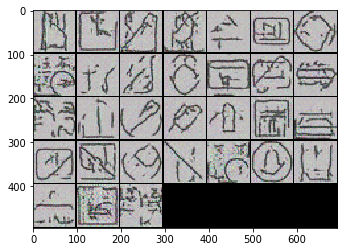

In [32]:
def r(ep=100000,noise_level=.01):
    sess = K.get_session()

    np.random.shuffle(xt)
    shuffled_cifar = xt
    length = len(shuffled_cifar)

    for i in range(ep):
        noise_level *= 0.99

        # sample from cifar
        j = i % int(length/batch_size)
        minibatch = shuffled_cifar[j*batch_size:(j+1)*batch_size]
        # minibatch += np.random.normal(loc=0.,scale=noise_level,size=subset_cifar.shape)

        z_input = np.random.normal(loc=0.,scale=1.,size=(batch_size,zed))

        # train for one step
        losses = gan_feed(sess,minibatch,z_input)
        if i % 1000 == 0:
            display.clear_output(wait=True)
            print('i:{:d} dloss:{:6.4f} gloss:{:6.4f}'.format(i, losses[0], losses[1]))
            show()
            plt.show()

#        if i==ep-1 or i % 10==0: show()
r()

i:99000 dloss:0.4672 gloss:2.5892


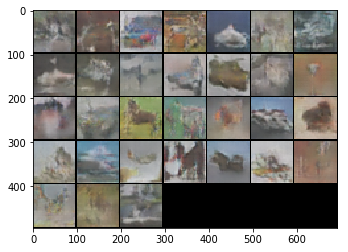

In [24]:
r(ep=100000, noise_level=.01)